In [1]:
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2

In [2]:
URL = 'https://www.opensecrets.org/races/candidates?cycle=2020&id=TN07&spec=N'

response = requests.get(URL)

In [3]:
response.status_code

200

In [4]:
soup_TN07 = BS(response.text)

In [5]:
#print(soup_TN07.prettify())

Alright, trying to find:
- the percentage of the vote that candidate received
- the total amount raised by that candidate (as a numeric variable)
- the total amount spent by the candidate (as a numeric variable)

In [6]:
# note1: the first [0] is to get the first candidate
# note2: the second [0] is there because otherwise read_html returns a list of tables
finances = (pd
    .read_html(
        str(soup_TN07.findAll('table', attrs={'class' : 'Members--table'})[0])
            .replace('$','')
            .replace(':', '')
    )[0]
    .pivot(index=2, columns=0, values=1)
    .reset_index(drop=True)
)

In [7]:
finances.head()

,Cash on Hand,Raised,Spent
0,287889,1194960,935487


In [8]:
finances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Cash on Hand  1 non-null      int64
 1   Raised        1 non-null      int64
 2   Spent         1 non-null      int64
dtypes: int64(3)
memory usage: 152.0 bytes


In [9]:
#soup_TN07.findAll('span', attrs={'class' : 'Members--vote-pct'})[0].text
re.search(r'\d{1,2}\.\d?%', soup_TN07.findAll('span', attrs={'class' : 'Members--vote-pct'})[0].text)[0]

'69.9%'

In [10]:
soup_TN07.findAll('h2')[0].find('i').text

'Incumbent'

In [11]:
soup_TN07.findAll('h2')[0].find('span', attrs={'class' : 'winner'}).text

'Winner'

In [12]:
candidate_info = soup_TN07.findAll('h2')[0].find('strong').text

In [13]:
print(candidate_info)


Mark Green (R) • Incumbent
 • Winner 
(69.9% of vote)



the regex below possibly includes sr., jr. and the likes

In [14]:
re.search(r'[A-Z][a-z]+ [A-Z][a-z]+ [A-Z0-9]?[a-z]?', candidate_info)[0].strip()

'Mark Green'

In [15]:
re.findall(r'\(([R,D])\)', candidate_info)[0]

'R'

In [16]:
if re.search(r'Incumbent', candidate_info)[0] == 'Incumbent':
    print('Incumbent')
else :
    print('Not Incumbent')

Incumbent


In [17]:
if re.search(r'Winner', candidate_info)[0] == 'Winner':
    print('Winner')
else :
    print('Loser')

Winner


In [18]:
re.search(r'[A-Z][a-z]+', soup_TN07.find('h1').text)[0]

'Tennessee'

In [19]:
re.findall(r'District (\d{2})', soup_TN07.find('h1').text)[0]

'07'

## working together

In [20]:
URL = 'https://www.opensecrets.org/races/candidates?cycle=2020&id=TN07&spec=N'
response = requests.get(URL)
soup = BS(response.text)

In [21]:
candidate_df = pd.DataFrame()

def district_scraper(soup):
    candidate_list = [x.text.strip() for x in soup.find_all('strong')]
    candidate_df['name'] = [re.findall(r'(.+ .+) \(\w', item)[0] for item in candidate_list]
    candidate_df['party'] = [re.findall(r'\((\w)\)', item)[0] for item in candidate_list]
    candidate_df['vote'] = [re.findall(r'(\d*[.?]\d*\%)', item)[0] for item in candidate_list]
    #candidate_df['winner'] = ['Winner' if re.search(r'Winner', item) != 'None' else 'Not Winner' for item in candidate_list]
    #[re.findall(r'(Winner)', item)[0] for item in candidate_list]
    #candidate_df['incumbent'] = [re.findall(r'(Incumbent)', item)[0] for item in candidate_list]

In [22]:
for item in [x.text.strip() for x in soup.find_all('strong')]:
    print(item)
    print(type(re.search(r'Winner', item)))

Mark Green (R) • Incumbent
 • Winner 
(69.9% of vote)
<class 're.Match'>
Kiran Sreepada (D)
										
(27.3% of vote)
<class 'NoneType'>
Ronald Brown (I)
										
(2.2% of vote)
<class 'NoneType'>
Scott Vieira Jr (I)
										
(0.6% of vote)
<class 'NoneType'>


In [23]:
candidate_df.head()

""


The code below is to format the finances tables (for each candidate) in the correct order

In [24]:
# intitialize empty data frame
final_finances = pd.DataFrame()

# create the list of all dataframe tables for candidates
finances = (pd
    .read_html(
        str(soup_TN07.findAll('table', attrs={'class' : 'Members--table'}))
            .replace('$','')
            .replace(':', '')
    )
)

In [25]:
print(finances)

[              0        1   2
0        Raised  1194960 NaN
1         Spent   935487 NaN
2  Cash on Hand   287889 NaN,               0       1   2
0        Raised  206644 NaN
1         Spent  207191 NaN
2  Cash on Hand       0 NaN,               0     1   2
0        Raised  1750 NaN
1         Spent     0 NaN
2  Cash on Hand  9006 NaN,               0     1   2
0        Raised   655 NaN
1         Spent  1049 NaN
2  Cash on Hand  -197 NaN]


In [26]:
# loop over the dataframes list
for fin in finances:
    final_finances = pd.concat(
        [final_finances,
        fin.pivot(index=2, columns=0, values=1).reset_index(drop=True)])

print(final_finances)
    

0  Cash on Hand   Raised   Spent
0        287889  1194960  935487
0             0   206644  207191
0          9006     1750       0
0          -197      655    1049


## Code below after working with team (final version)

In [27]:
candidate_df = pd.DataFrame()

def district_scraper(state, district):
    URL = f'https://www.opensecrets.org/races/candidates?cycle=2020&id={state}{district}&spec=N'
    soup = BS(requests.get(URL).text)
    
    candidate_list = [x.text.strip() for x in soup.find_all('strong')]
    
    finances = (pd
        .read_html(
            str(soup.findAll('table', attrs={'class' : 'Members--table'}))
                .replace('$','')
                .replace(':', '')
        )
    )
    
    temp_df = pd.DataFrame()

    temp_df['name'] = [re.findall(r'(.+ .+) \(\w', item)[0] for item in candidate_list]
    temp_df['party'] = [re.findall(r'\((\w)\)', item)[0] for item in candidate_list]
    temp_df['vote'] = [re.findall(r'(\d*[.?]\d*\%)', item)[0] for item in candidate_list]
    temp_df['winner'] = ['Winner' if re.search(r'(Winner)', str(item)) is not None
                              else 'Not Winner' for item in candidate_list]
    temp_df['incumbent'] = ['Incumbent' if re.search(r'(Incumbent)', str(item)) != None 
                            else 'Not Incumbent' for item in candidate_list]
    temp_df['state'] = str(re.search(r'[A-Z][a-z]+(?: [A-Z][a-hj-z][a-z]+)?',
                                     soup.findAll('title')[0].text)[0])
    temp_df['district'] = str(re.findall(r'District ([0-9]{2})', soup.findAll('title')[0].text)[0])
    temp_df['raised'] = [finances[i].iloc[0,1] for i in range(len(candidate_list))]
    temp_df['spent'] = [finances[i].iloc[1,1] for i in range(len(candidate_list))]
    temp_df['cash_on_hand'] = [finances[i].iloc[2,1] for i in range(len(candidate_list))]
    
    global candidate_df
    candidate_df = pd.concat([candidate_df, temp_df])
    candidate_df = candidate_df.reset_index(drop=True)

In [28]:
#the handy zfill function gives you a 0 with single digit numbers!

for num in range(1,10):
    district_scraper('TN', str(num).zfill(2))

In [29]:
candidate_df

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand
0,Diana Harshbarger,R,74.8%,Winner,Not Incumbent,Tennessee,01,2126946,1869100,257846
1,Blair Nicole Walsingham,D,22.4%,Not Winner,Not Incumbent,Tennessee,01,140209,134995,5215
2,Tim Burchett,R,67.7%,Winner,Incumbent,Tennessee,02,1336276,878488,593678
3,Renee Hoyos,D,31.0%,Not Winner,Not Incumbent,Tennessee,02,812784,816793,210
4,Chuck Fleischmann,R,67.3%,Winner,Incumbent,Tennessee,03,1051653,381411,1880341
5,Meg Gorman,D,30.5%,Not Winner,Not Incumbent,Tennessee,03,85843,77760,8083
6,Scott Desjarlais,R,66.7%,Winner,Incumbent,Tennessee,04,331464,392499,302649
7,Christopher Hale,D,33.3%,Not Winner,Not Incumbent,Tennessee,04,308731,302996,5735
8,Jim Cooper,D,100.0%,Winner,Incumbent,Tennessee,05,936569,1332131,272934
9,John Rose,R,73.7%,Winner,Incumbent,Tennessee,06,1050429,625688,454375


In [30]:
URL2 = 'https://www.britannica.com/topic/United-States-House-of-Representatives-Seats-by-State-1787120'

soup_house_rep = BS(requests.get(URL2).text)

In [31]:
house_rep = pd.read_html(str(soup_house_rep.findAll('table')))[0].drop(index=50)

In [32]:
house_rep.head()

,state,representatives
0,Alabama,7
1,Alaska,1
2,Arizona,9
3,Arkansas,4
4,California,53


In [33]:
URL3 = 'https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes'

soup_stateabbr = BS(requests.get(URL3).text)

In [34]:
request_url = requests.get(URL3)
tm=0
while request_url.status_code != 200:
    print('no work')
    time.sleep(1)
    request_url = requests.get(URL3)
    tm = tm + 1
    if tm == 10:
        break

#print(BS(request_url.text))


In [35]:
postal = pd.read_html(str(soup_stateabbr.findAll('table')))[0].rename(columns={'State Name/District' : 'state'})

In [36]:
postal.head()

,state,Postal Abbreviation,Postal Code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [37]:
house_rep_postal = pd.merge(house_rep, postal, how="inner", on='state')

In [38]:
house_rep_postal.head()

,state,representatives,Postal Abbreviation,Postal Code
0,Alabama,7,Ala.,AL
1,Alaska,1,Alaska,AK
2,Arizona,9,Ariz.,AZ
3,Arkansas,4,Ark.,AR
4,California,53,Calif.,CA


In [39]:
district_dictionary = house_rep_postal.set_index('Postal Code')['representatives'].to_dict()

## testing my own variation

In [40]:
candidate_df = pd.DataFrame()

def district_scraper(state, district):
    URL = f'https://www.opensecrets.org/races/candidates?cycle=2020&id={state}{district}&spec=N'
    
    request_url = requests.get(URL)
    tm=0

    while request_url.status_code != 200:
        print('waiting for ' + state + district)
        time.sleep(10)
        request_url = requests.get(URL)
        tm = tm + 1
        if tm == 10:
            break

    soup = BS(request_url.text)

    candidate_list = [x.text.strip() for x in soup.find_all('strong')]
    
    finances = (pd
        .read_html(
            str(soup.findAll('table', attrs={'class' : 'Members--table'}))
                .replace('$','')
                .replace(':', '')
        )
    )
    
    temp_df = pd.DataFrame()

    temp_df['name'] = [re.findall(r'(.+ .+) \(\w', item)[0] for item in candidate_list]
    temp_df['party'] = [re.findall(r'\((\w)\)', item)[0] for item in candidate_list]
    temp_df['vote'] = [re.findall(r'(\d*[.?]\d*\%)', item)[0] for item in candidate_list]
    temp_df['winner'] = ['Winner' if re.search(r'(Winner)', str(item)) is not None
                              else 'Not Winner' for item in candidate_list]
    temp_df['incumbent'] = ['Incumbent' if re.search(r'(Incumbent)', str(item)) != None 
                            else 'Not Incumbent' for item in candidate_list]
    temp_df['state'] = str(re.search(r'[A-Z][a-z]+(?: [A-Z][a-z][a-rt-z][a-z]+)?', soup.findAll('title')[0].text)[0])

    temp_df['district'] = str(re.findall(r'District ([0-9]{2})', soup.findAll('title')[0].text)[0])
    temp_df['raised'] = [finances[i].iloc[0,1] for i in range(len(candidate_list))]
    temp_df['spent'] = [finances[i].iloc[1,1] for i in range(len(candidate_list))]
    temp_df['cash_on_hand'] = [finances[i].iloc[2,1] for i in range(len(candidate_list))]

    #funding source
    funding_source = (pd
        .read_html(
            str([table for table in soup.findAll('table') 
                    if re.search(r'(Type of Contribution)', str(table)) != None ]
                )
                .replace('$','')
        )
    )

    temp_df['Small Individual Contributions (≤ 200)'] = [funding_source[i].iloc[0,1] for i in range(len(candidate_list))]
    temp_df['Large Individual Contributions'] = [funding_source[i].iloc[1,1] for i in range(len(candidate_list))]
    temp_df['PAC Contributions*'] = [funding_source[i].iloc[2,1] for i in range(len(candidate_list))]
    temp_df['Candidate self-financing'] = [funding_source[i].iloc[3,1] for i in range(len(candidate_list))]
    temp_df['Other'] = [funding_source[i].iloc[4,1] for i in range(len(candidate_list))]


    global candidate_df
    candidate_df = pd.concat([candidate_df, temp_df])
    candidate_df = candidate_df.reset_index(drop=True)

In [41]:
candidate_df = pd.DataFrame()
fail_list =[]

for state, dist in district_dictionary.items():
    try:
        for num in range(1, dist +1): 
            district_scraper(state, str(num).zfill(2))

    except: 
        fail_list.append((state, dist))

fail_list

waiting for MN04
waiting for MN04
waiting for MN04
waiting for MN04
waiting for MN04
waiting for MN04
waiting for MN04


[]

In [42]:
candidate_df

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand,Small Individual Contributions (≤ 200),Large Individual Contributions,PAC Contributions*,Candidate self-financing,Other
0,Jerry Carl,R,64.9%,Winner,Not Incumbent,Alabama,01,1971321,1859349,111973,44580,999616,387000,434656,105470
1,James Averhart,D,35.0%,Not Winner,Not Incumbent,Alabama,01,80095,78973,1122,12895,37955,0,29245,0
2,Barry Moore,R,65.3%,Winner,Not Incumbent,Alabama,02,650807,669368,-13633,62208,346329,230282,11500,489
3,Phyllis Harvey-Hall,D,34.6%,Not Winner,Not Incumbent,Alabama,02,56050,55988,0,15307,27105,2032,10575,1030
4,Mike D Rogers,R,67.5%,Winner,Incumbent,Alabama,03,1193111,1218564,502234,5315,438054,744734,0,5009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,Tricia Zunker,D,39.2%,Not Winner,Not Incumbent,Wisconsin,07,1261957,1232690,29267,600015,566860,91807,0,3276
888,Mike Gallagher,R,64.0%,Winner,Incumbent,Wisconsin,08,3202905,2841801,1169362,188430,2040299,841300,0,132876
889,Amanda Stuck,D,36.0%,Not Winner,Not Incumbent,Wisconsin,08,416978,399916,2165,169380,221453,30183,0,-4038
890,Liz Cheney,R,68.6%,Winner,Incumbent,Wyoming,01,3003883,3060167,153567,189647,980349,1292490,0,541398


4. Using your scraped data, investigates different relationships between candidates and the amount of money they raised. Here are some suggestions to get you started, but feel free to pose you own questions or do additional exploration:
- How often does the candidate who raised more money win a race?
> 88.3% of time

In [43]:
candidate_df[
    candidate_df['raised']
    .isin(candidate_df.groupby(by=['state', 'district'])['raised'].max())
    ].groupby(by='winner').count()

,name,party,vote,incumbent,state,district,raised,spent,cash_on_hand,Small Individual Contributions (≤ 200),Large Individual Contributions,PAC Contributions*,Candidate self-financing,Other
winner,,,,,,,,,,,,,,
Not Winner,51,51,51,51,51,51,51,51,51,51,51,51,51,51
Winner,384,384,384,384,384,384,384,384,384,384,384,384,384,384


In [44]:
384/435

0.8827586206896552

In [45]:
# the transform applies the 'max' value to undo the grouping essentially; the .to_frame() makes it a dataframe again
candidate_df.groupby(['state', 'district'])['raised'].transform('max').to_frame()

,raised
0,1971321
1,1971321
2,650807
3,650807
4,1193111
...,...
887,2637459
888,3202905
889,3202905
890,3003883


- How often does the candidate who spent more money win a race?
> 87.6%

In [46]:
candidate_df[
    candidate_df['spent']
    .isin(candidate_df.groupby(by=['state', 'district'])['spent'].max())
    ].groupby(by='winner').count()

,name,party,vote,incumbent,state,district,raised,spent,cash_on_hand,Small Individual Contributions (≤ 200),Large Individual Contributions,PAC Contributions*,Candidate self-financing,Other
winner,,,,,,,,,,,,,,
Not Winner,54,54,54,54,54,54,54,54,54,54,54,54,54,54
Winner,381,381,381,381,381,381,381,381,381,381,381,381,381,381


In [47]:
381/435

0.8758620689655172

- Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?

In [48]:
candidate_df['diff_raised'] = candidate_df.groupby(by=['state', 'district'])['raised'].transform('max') - candidate_df['raised']

In [49]:
candidate_df['diff_spent'] = candidate_df.groupby(by=['state', 'district'])['spent'].transform('max') - candidate_df['spent']

In [50]:
candidate_df.head()

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand,Small Individual Contributions (≤ 200),Large Individual Contributions,PAC Contributions*,Candidate self-financing,Other,diff_raised,diff_spent
0,Jerry Carl,R,64.9%,Winner,Not Incumbent,Alabama,01,1971321,1859349,111973,44580,999616,387000,434656,105470,0,0
1,James Averhart,D,35.0%,Not Winner,Not Incumbent,Alabama,01,80095,78973,1122,12895,37955,0,29245,0,1891226,1780376
2,Barry Moore,R,65.3%,Winner,Not Incumbent,Alabama,02,650807,669368,-13633,62208,346329,230282,11500,489,0,0
3,Phyllis Harvey-Hall,D,34.6%,Not Winner,Not Incumbent,Alabama,02,56050,55988,0,15307,27105,2032,10575,1030,594757,613380
4,Mike D Rogers,R,67.5%,Winner,Incumbent,Alabama,03,1193111,1218564,502234,5315,438054,744734,0,5009,0,0


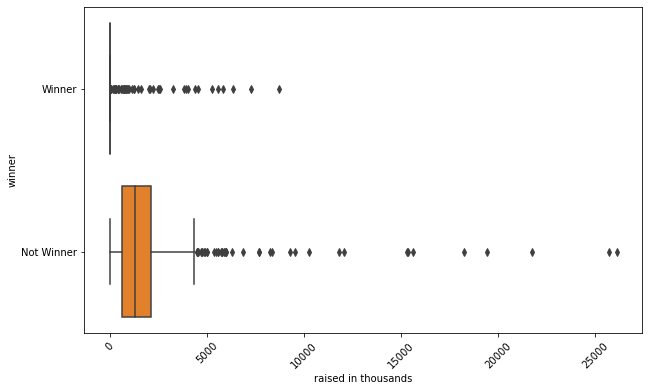

In [51]:
fig, ax = plt.subplots(figsize = (10,6)) #this makes the plot larger, by scaling the axis

sns.boxplot(
    data = candidate_df,
    x = (candidate_df['diff_raised']/1000),
    y = 'winner',
    ax=ax
)
plt.xticks(rotation = 45) #to rotate the x axis
plt.xlabel('raised in thousands'); 

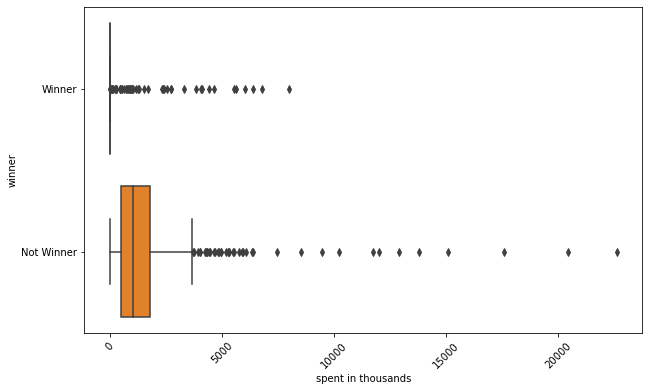

In [52]:
fig, ax = plt.subplots(figsize = (10,6)) #this makes the plot larger, by scaling the axis

sns.boxplot(
    data = candidate_df,
    x = (candidate_df['diff_spent']/1000),
    y = 'winner',
    ax=ax
)
plt.xticks(rotation = 45) #to rotate the x axis
plt.xlabel('spent in thousands'); 

the two plots above show even mroe significantly how the winners are typically the ones who spend (or raise) the most.

- How often does the incumbent candidate win a race?
> 85.3%

In [53]:
candidate_df[candidate_df['incumbent'] == 'Incumbent'].groupby(by='winner').count()

,name,party,vote,incumbent,state,district,raised,spent,cash_on_hand,Small Individual Contributions (≤ 200),Large Individual Contributions,PAC Contributions*,Candidate self-financing,Other,diff_raised,diff_spent
winner,,,,,,,,,,,,,,,,
Not Winner,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
Winner,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371


In [54]:
371/435

0.8528735632183908

- Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


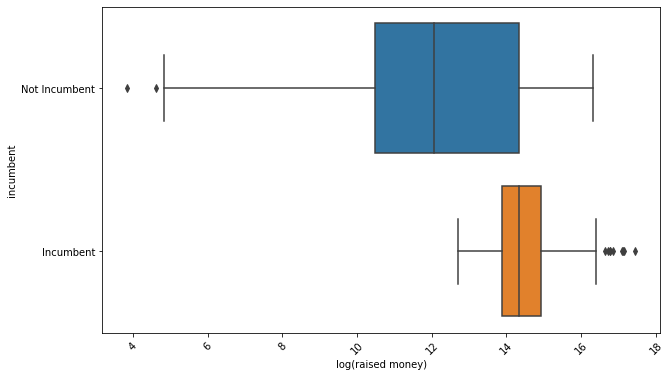

In [55]:
fig, ax = plt.subplots(figsize = (10,6)) #this makes the plot larger, by scaling the axis

sns.boxplot(
    data = candidate_df,
    x = np.log(candidate_df['raised']),
    y = 'incumbent',
    ax=ax
)
plt.xticks(rotation = 45) #to rotate the x axis
plt.xlabel('log(raised money)');

In [56]:
pd.read_html(str(soup_TN07.findAll('table', attrs={'class' : 'Members--table'})[0]).replace('$','').replace(':', ''))[0]


,0,1,2
0,Raised,1194960,NaN
1,Spent,935487,NaN
2,Cash on Hand,287889,NaN


In [57]:
soup_TN07.findAll('div', attrs={'class' : 'u-richtext'})[2]

<div class="u-richtext">
<h3>Source of Funds</h3>
<table>
<thead>
<tr>
<th scope="col">Type of Contribution</th>
<th class="number" scope="col">Amount</th>
<th class="number" scope="col">Percentage</th>
</tr>
</thead>
<tbody>
<tr>
<td>Small Individual Contributions (≤ $200)</td>
<td class="number">$0</td>
<td class="number">0.00%</td>
</tr>
<tr>
<td>Large Individual Contributions</td>
<td class="number">$819,151</td>
<td class="number">68.55%</td>
</tr>
<tr>
<td>PAC Contributions*</td>
<td class="number">$171,900</td>
<td class="number">14.39%</td>
</tr>
<tr>
<td>Candidate self-financing</td>
<td class="number">$0</td>
<td class="number">0.00%</td>
</tr>
<tr>
<td>Other</td>
<td class="number">$203,909</td>
<td class="number">17.06%</td>
</tr>
</tbody>
</table>
<h3>Quality of Disclosure</h3>
<table>
<thead>
<tr>
<th scope="col">Type of Disclosure</th>
<th class="number" scope="col">Amount</th>
<th class="number" scope="col">Percentage</th>
</tr>
</thead>
<tbody>
<tr>
<td nowrap="">Full 

In [58]:
source_funds = [table for table in soup_TN07.findAll('table') if re.search(r'(Type of Contribution)', str(table)) != None ]

In [59]:
source_funds

[<table>
 <thead>
 <tr>
 <th scope="col">Type of Contribution</th>
 <th class="number" scope="col">Amount</th>
 <th class="number" scope="col">Percentage</th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td>Small Individual Contributions (≤ $200)</td>
 <td class="number">$0</td>
 <td class="number">0.00%</td>
 </tr>
 <tr>
 <td>Large Individual Contributions</td>
 <td class="number">$819,151</td>
 <td class="number">68.55%</td>
 </tr>
 <tr>
 <td>PAC Contributions*</td>
 <td class="number">$171,900</td>
 <td class="number">14.39%</td>
 </tr>
 <tr>
 <td>Candidate self-financing</td>
 <td class="number">$0</td>
 <td class="number">0.00%</td>
 </tr>
 <tr>
 <td>Other</td>
 <td class="number">$203,909</td>
 <td class="number">17.06%</td>
 </tr>
 </tbody>
 </table>,
 <table>
 <thead>
 <tr>
 <th scope="col">Type of Contribution</th>
 <th class="number" scope="col">Amount</th>
 <th class="number" scope="col">Percentage</th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td>Small Individual Contributions (≤ $200)</td>
 

In [60]:
contributions = pd.read_html(str(source_funds[0]).replace('$',''))[0]

In [61]:
# if I wanted to pivot and collapse the table, I need to create a dummy column to use as index
# contributions['dummy'] = 1
# contributions.pivot(index='dummy', columns='Type of Contribution', values='Amount').reset_index(drop=True).rename_axis(None, axis=1)

In [62]:
contributions.head()

,Type of Contribution,Amount,Percentage
0,Small Individual Contributions (≤ 200),0,0.00%
1,Large Individual Contributions,819151,68.55%
2,PAC Contributions*,171900,14.39%
3,Candidate self-financing,0,0.00%
4,Other,203909,17.06%


In [63]:
# get all 5 values!
[contributions.iloc[i,1] for i in range(5)]


[0, 819151, 171900, 0, 203909]

In [64]:
# just combining all the info from above into the same function, for first candidate - index at the ent [0]
pd.read_html(str([table for table in soup_TN07.findAll('table') if re.search(r'(Type of Contribution)', str(table)) != None ]).replace('$',''))[0]

,Type of Contribution,Amount,Percentage
0,Small Individual Contributions (≤ 200),0,0.00%
1,Large Individual Contributions,819151,68.55%
2,PAC Contributions*,171900,14.39%
3,Candidate self-financing,0,0.00%
4,Other,203909,17.06%


# An Analysis of Political Contributions During the 2020 House of Representatives Election, Part 2

For the first part of this project, you scraped information for all House of Representatives races during 2020 and performed some exploratory analysis.

Now, take the data you gathered and fit a logistic regression model to see if the amount spent has a statistically significant impact on the probability of winning an election.

Feel free to brainstorm ways to set up your model, but a suggestion to get started would be to calculate, for each candidate, the percentage of to total amount spent in their race that was spent by them and use this as your predictor variable of interest. Hint: you may find the `transform` method (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html) in combination with `groupby` useful to find the total spending by race.

Don't forget to include the incumbent variable in your model.

After fitting your model, interpret the meaning of the coefficients you get.

In [65]:
candidate_df.head(2)

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand,Small Individual Contributions (≤ 200),Large Individual Contributions,PAC Contributions*,Candidate self-financing,Other,diff_raised,diff_spent
0,Jerry Carl,R,64.9%,Winner,Not Incumbent,Alabama,01,1971321,1859349,111973,44580,999616,387000,434656,105470,0,0
1,James Averhart,D,35.0%,Not Winner,Not Incumbent,Alabama,01,80095,78973,1122,12895,37955,0,29245,0,1891226,1780376


In [66]:
candidate_df['win_flag'] = [1 if x == 'Winner' else 0 for x in candidate_df['winner']]

In [67]:
candidate_df['incumbent_flag'] = [1 if x == 'Incumbent' else 0 for x in candidate_df['incumbent']]

In [68]:
# alternative to the above
# all_candidates['winner_dum'] = pd.get_dummies(all_candidates['winner'])['Winner']

In [69]:
candidate_df.head(2)

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand,Small Individual Contributions (≤ 200),Large Individual Contributions,PAC Contributions*,Candidate self-financing,Other,diff_raised,diff_spent,win_flag,incumbent_flag
0,Jerry Carl,R,64.9%,Winner,Not Incumbent,Alabama,01,1971321,1859349,111973,44580,999616,387000,434656,105470,0,0,1,0
1,James Averhart,D,35.0%,Not Winner,Not Incumbent,Alabama,01,80095,78973,1122,12895,37955,0,29245,0,1891226,1780376,0,0


In [70]:
# to get the total money spent in each district
candidate_df['spent_by_district'] = candidate_df.groupby(['state', 'district'])['spent'].transform(sum)

In [71]:
# percentage of money spent by candidate in district
candidate_df['percentage_spent'] = candidate_df['spent'] / candidate_df['spent_by_district'] * 100

In [72]:
candidate_df.head(2)

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand,...,Large Individual Contributions,PAC Contributions*,Candidate self-financing,Other,diff_raised,diff_spent,win_flag,incumbent_flag,spent_by_district,percentage_spent
0,Jerry Carl,R,64.9%,Winner,Not Incumbent,Alabama,01,1971321,1859349,111973,...,999616,387000,434656,105470,0,0,1,0,1938322,95.925703
1,James Averhart,D,35.0%,Not Winner,Not Incumbent,Alabama,01,80095,78973,1122,...,37955,0,29245,0,1891226,1780376,0,0,1938322,4.074297


In [73]:
reduced_model = smf.logit('win_flag ~ 1',
                        data = candidate_df).fit()

Optimization terminated successfully.
         Current function value: 0.692582
         Iterations 3


In [74]:
win_spend_logreg = smf.logit('win_flag ~ percentage_spent',
                            data = candidate_df).fit()

Optimization terminated successfully.
         Current function value: 0.243755
         Iterations 8


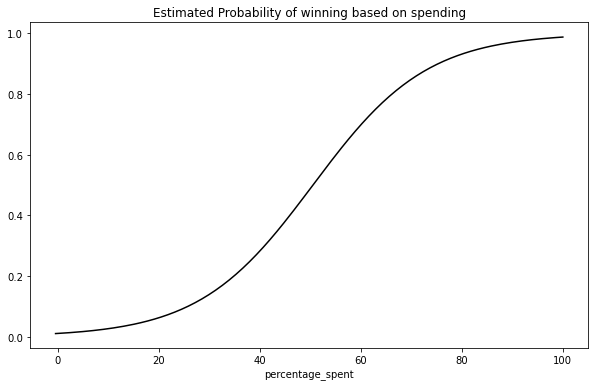

In [75]:
fit_df = pd.DataFrame({
    'percentage_spent': np.linspace(start = candidate_df['percentage_spent'].min(),
                            stop = candidate_df['percentage_spent'].max(),
                            num = 150)
})

fit_df['fit'] = win_spend_logreg.predict(fit_df)

fit_df.plot(x = 'percentage_spent',
             y = 'fit',
             legend = False,
             figsize = (10,6),
             color = 'black',
            title = 'Estimated Probability of winning based on spending');

In [76]:
win_summary = (
    candidate_df
    .assign(group = pd.qcut(candidate_df['percentage_spent'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group')
    ['win_flag', 'percentage_spent']
    .mean()
    .reset_index()
    .rename(columns = {'win_flag': 'eprob'})
)

/var/folders/3t/x8rz35tn765cm0bkf_n4ydlh0000gn/T/ipykernel_58351/1118825022.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  candidate_df


In [77]:
win_summary['fit_prob'] = win_spend_logreg.predict(win_summary[['percentage_spent']])
win_summary

,group,eprob,percentage_spent,fit_prob
0,"(-0.393, 0.975]",0.000000,0.283931,0.011537
1,"(0.975, 4.76]",0.000000,2.692317,0.014241
2,"(4.76, 14.525]",0.011236,8.526336,0.023646
3,"(14.525, 31.438]",0.146067,23.098337,0.080901
4,"(31.438, 47.719]",0.325843,39.388358,0.271400
5,"(47.719, 64.64]",0.561798,55.850561,0.615466
6,"(64.64, 81.838]",0.820225,72.576838,0.875623
7,"(81.838, 94.023]",0.977528,88.782014,0.967287
8,"(94.023, 98.987]",0.988764,96.582448,0.983333
9,"(98.987, 100.0]",1.000000,99.857718,0.987477


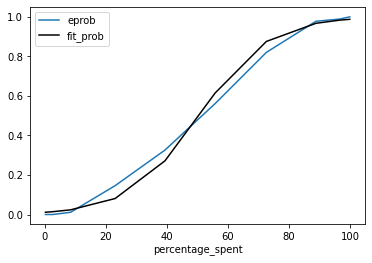

In [78]:
ax = win_summary.plot(x = 'percentage_spent', y = 'eprob')
win_summary.plot(x = 'percentage_spent', y = 'fit_prob',
                color = 'black',
                ax = ax);

In [79]:
def dd_test(reduced_model, full_model):
    G2 = -2 * (reduced_model.llf - full_model.llf)
    df = full_model.df_model - reduced_model.df_model
    return chi2.sf(G2, df = df)

In [80]:
dd_test(reduced_model, win_spend_logreg)

3.7900959342976285e-176

In [81]:
full_model = smf.logit('win_flag ~ incumbent_flag + percentage_spent',
                        data = candidate_df).fit()

Optimization terminated successfully.
         Current function value: 0.182464
         Iterations 8


In [82]:
dd_test(win_spend_logreg, full_model)

1.3641003638762768e-25

In [83]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               win_flag   No. Observations:                  892
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Oct 2022   Pseudo R-squ.:                  0.7365
Time:                        13:28:53   Log-Likelihood:                -162.76
converged:                       True   LL-Null:                       -617.78
Covariance Type:            nonrobust   LLR p-value:                2.428e-198
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.3755      0.333    -13.136      0.000      -5.028      -3.723
incumbent_flag       3.2072      0.339      9.467      0.000       2.543       3.871
percentage_spent     0.0623      0.006     10.546      0.000       0.051       0.074
====================================================================================
"""

Incumbent candidates have a much higher probability to win than non. That factor matters much more than the money spent.

In [84]:
interaction_model = smf.logit('win_flag ~ incumbent_flag + percentage_spent + incumbent_flag:percentage_spent',
                        data = candidate_df).fit()

Optimization terminated successfully.
         Current function value: 0.181391
         Iterations 8


In [85]:
dd_test(full_model, interaction_model)

0.16651127921676967

In [86]:
candidate_df.head(2)

,name,party,vote,winner,incumbent,state,district,raised,spent,cash_on_hand,...,Large Individual Contributions,PAC Contributions*,Candidate self-financing,Other,diff_raised,diff_spent,win_flag,incumbent_flag,spent_by_district,percentage_spent
0,Jerry Carl,R,64.9%,Winner,Not Incumbent,Alabama,01,1971321,1859349,111973,...,999616,387000,434656,105470,0,0,1,0,1938322,95.925703
1,James Averhart,D,35.0%,Not Winner,Not Incumbent,Alabama,01,80095,78973,1122,...,37955,0,29245,0,1891226,1780376,0,0,1938322,4.074297


## Additional exploration Questions

- What does the overall distribution of funding sources look like?
- Is there any detectable difference in contribution sources between Democrat and Republican candidates?
- Do the funding sources for either the winning candidate or incumbent candidate differ from the other candidates?

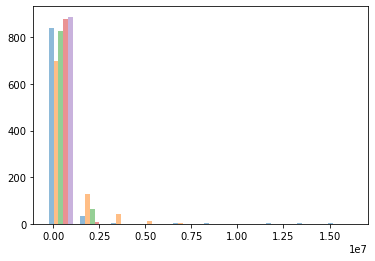

In [87]:
plt.hist([
    candidate_df['Small Individual Contributions (≤ 200)'],
    candidate_df['Large Individual Contributions'],
    candidate_df['PAC Contributions*'],
    candidate_df['Candidate self-financing'],
    candidate_df['Other']
    ],
    alpha=0.5,
    bins=10
);

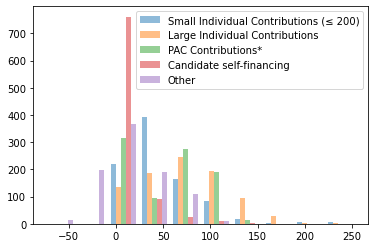

In [88]:
plt.hist([
    np.cbrt(candidate_df['Small Individual Contributions (≤ 200)']),
    np.cbrt(candidate_df['Large Individual Contributions']),
    np.cbrt(candidate_df['PAC Contributions*']),
    np.cbrt(candidate_df['Candidate self-financing']),
    np.cbrt(candidate_df['Other'])
    ],
    alpha=0.5,
    bins=10
);
plt.legend(['Small Individual Contributions (≤ 200)', 'Large Individual Contributions', 'PAC Contributions*', 'Candidate self-financing', 'Other'])

note: couldn't do log directly because of some 0 values or negative ones.

> observations: Some of the 'other' contributions are negative. why? As small individual contributions and candidate self-financing peaks at lower values than large ind. contributions and PAC contributions

In [89]:
candidate_df.describe()

,raised,spent,cash_on_hand,Small Individual Contributions (≤ 200),Large Individual Contributions,PAC Contributions*,Candidate self-financing,Other,diff_raised,diff_spent,win_flag,incumbent_flag,spent_by_district,percentage_spent
count,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,892.000000,892.000000,8.920000e+02,892.000000
mean,1.869719e+06,1.687890e+06,4.145076e+05,4.234739e+05,8.909687e+05,4.150407e+05,5.572106e+04,8.462074e+04,1.126903e+06,9.592798e+05,0.483184,0.432735,3.603903e+06,48.766816
std,3.028104e+06,2.627025e+06,1.046607e+06,1.454744e+06,1.354832e+06,5.056065e+05,3.676646e+05,3.956457e+05,2.393864e+06,1.984299e+06,0.499997,0.495733,4.277784e+06,37.582099
min,-2.084000e+03,-4.965000e+03,-5.135500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.159300e+05,0.000000e+00,0.000000e+00,0.000000,0.000000,1.056600e+05,-0.392057
25%,1.300595e+05,1.132970e+05,2.594250e+03,1.434725e+04,4.684875e+04,3.815000e+03,0.000000e+00,-4.722500e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,1.116666e+06,7.659950
50%,1.088816e+06,9.476810e+05,5.000200e+04,6.376200e+04,4.091095e+05,2.564295e+05,0.000000e+00,8.005000e+02,2.317050e+05,1.238850e+05,0.000000,0.000000,1.825329e+06,47.719279
75%,2.265568e+06,2.037730e+06,4.106440e+05,2.887590e+05,1.081924e+06,6.705528e+05,2.800000e+03,5.915675e+04,1.414926e+06,1.194052e+06,1.000000,1.000000,4.231620e+06,89.409688
max,3.726283e+07,3.283061e+07,1.390827e+07,1.643459e+07,1.458320e+07,3.127684e+06,6.921255e+06,9.608903e+06,2.610954e+07,2.260021e+07,1.000000,1.000000,3.283061e+07,100.000000


In [97]:
candidate_df['party'].unique()

numpy.ndarray

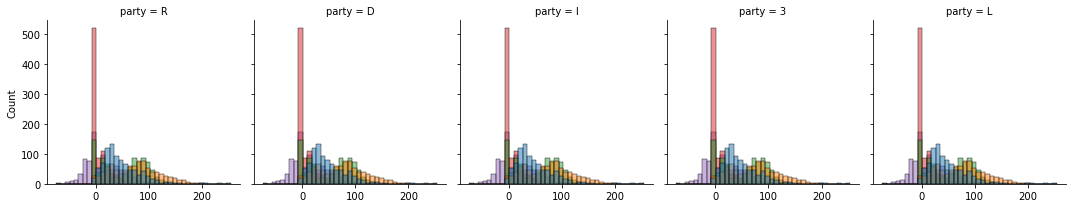

In [140]:
g = sns.FacetGrid(
candidate_df,
col='party'
)
g.map(sns.histplot, data=[
    np.cbrt(candidate_df['Small Individual Contributions (≤ 200)']),
    np.cbrt(candidate_df['Large Individual Contributions']),
    np.cbrt(candidate_df['PAC Contributions*']),
    np.cbrt(candidate_df['Candidate self-financing']),
    np.cbrt(candidate_df['Other'])
    ]
);

# why does this not work?


In [176]:
candidate_df['log Small Contr'] = [
    (-1)* np.log(contribution* (-1)) if contribution < 0
    else 0 if contribution < 1
    else np.log(contribution)
    for contribution in candidate_df['Small Individual Contributions (≤ 200)']
]
candidate_df['log Large Contr'] = [
    (-1)* np.log(contribution* (-1)) if contribution < 0
    else 0 if contribution < 1
    else np.log(contribution)
    for contribution in candidate_df['Large Individual Contributions']
]
candidate_df['log PAC'] = [
    (-1)* np.log(contribution* (-1)) if contribution < 0
    else 0 if contribution < 1
    else np.log(contribution)
    for contribution in candidate_df['PAC Contributions*']
]
candidate_df['log Self'] = [
    (-1)* np.log(contribution* (-1)) if contribution < 0
    else 0 if contribution < 1
    else np.log(contribution)
    for contribution in candidate_df['Candidate self-financing']
]
candidate_df['log Other'] = [
    (-1)* np.log(contribution* (-1)) if contribution < 0
    else 0 if contribution < 1
    else np.log(contribution)
    for contribution in candidate_df['Other']
]

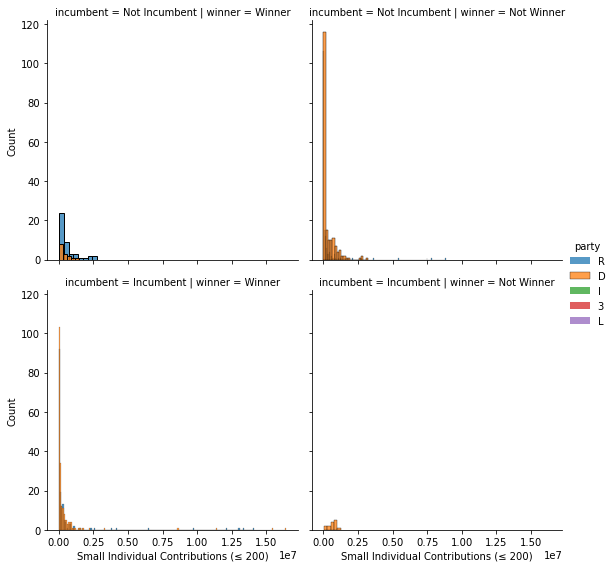

In [174]:
g = sns.FacetGrid(
candidate_df,
height=4,
col='winner',
row='incumbent',
hue='party'
)
g.map(sns.histplot, 'Small Individual Contributions (≤ 200)')
#g.map(sns.histplot, 'Large Individual Contributions')
#g.map(sns.histplot, 'PAC Contributions*')
#g.map(sns.histplot, 'Candidate self-financing')
#g.map(sns.histplot, 'Other')
g.add_legend();

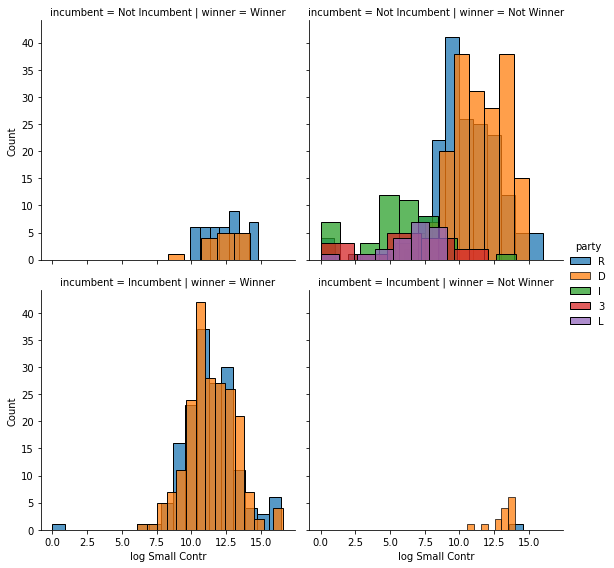

In [183]:
g = sns.FacetGrid(
candidate_df,
height=4,
col='winner',
row='incumbent',
hue='party'
)
g.map(sns.histplot, 'log Small Contr')
#g.map(sns.histplot, 'log Large Contr')
#g.map(sns.histplot, 'log PAC')
#g.map(sns.histplot, 'log Self')
#g.map(sns.histplot, 'log Other')
g.add_legend();


In [112]:
type(pd.Series(candidate_df['party'].unique()))

pandas.core.series.Series

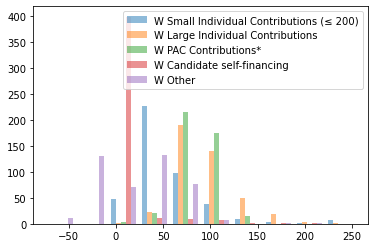

In [92]:
plt.hist([
    np.cbrt(candidate_df[candidate_df['winner']=='Winner']['Small Individual Contributions (≤ 200)']),
    np.cbrt(candidate_df[candidate_df['winner']=='Winner']['Large Individual Contributions']),
    np.cbrt(candidate_df[candidate_df['winner']=='Winner']['PAC Contributions*']),
    np.cbrt(candidate_df[candidate_df['winner']=='Winner']['Candidate self-financing']),
    np.cbrt(candidate_df[candidate_df['winner']=='Winner']['Other'])
    ],
    alpha=0.5,
    bins=10
);
plt.legend(['W Small Individual Contributions (≤ 200)', 'W Large Individual Contributions', 'W PAC Contributions*', 'W Candidate self-financing', 'W Other'])

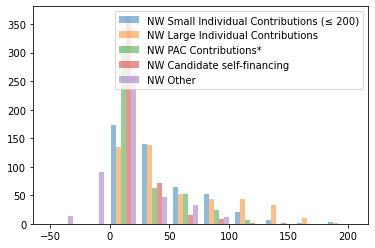

In [93]:
plt.hist([
    np.cbrt(candidate_df[candidate_df['winner']=='Not Winner']['Small Individual Contributions (≤ 200)']),
    np.cbrt(candidate_df[candidate_df['winner']=='Not Winner']['Large Individual Contributions']),
    np.cbrt(candidate_df[candidate_df['winner']=='Not Winner']['PAC Contributions*']),
    np.cbrt(candidate_df[candidate_df['winner']=='Not Winner']['Candidate self-financing']),
    np.cbrt(candidate_df[candidate_df['winner']=='Not Winner']['Other'])
    ],
    alpha=0.5,
    bins=10
);
plt.legend(['NW Small Individual Contributions (≤ 200)', 'NW Large Individual Contributions', 'NW PAC Contributions*', 'NW Candidate self-financing', 'NW Other'])

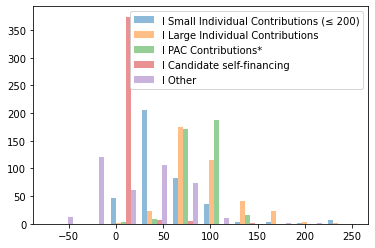

In [95]:
plt.hist([
    np.cbrt(candidate_df[candidate_df['incumbent']=='Incumbent']['Small Individual Contributions (≤ 200)']),
    np.cbrt(candidate_df[candidate_df['incumbent']=='Incumbent']['Large Individual Contributions']),
    np.cbrt(candidate_df[candidate_df['incumbent']=='Incumbent']['PAC Contributions*']),
    np.cbrt(candidate_df[candidate_df['incumbent']=='Incumbent']['Candidate self-financing']),
    np.cbrt(candidate_df[candidate_df['incumbent']=='Incumbent']['Other'])
    ],
    alpha=0.5,
    bins=10
);
plt.legend(['I Small Individual Contributions (≤ 200)', 'I Large Individual Contributions', 'I PAC Contributions*', 'I Candidate self-financing', 'I Other'])

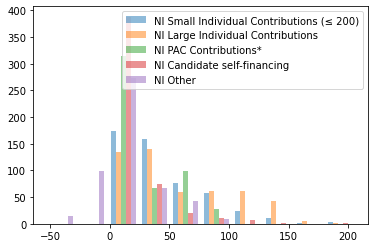

In [94]:
plt.hist([
    np.cbrt(candidate_df[candidate_df['incumbent']=='Not Incumbent']['Small Individual Contributions (≤ 200)']),
    np.cbrt(candidate_df[candidate_df['incumbent']=='Not Incumbent']['Large Individual Contributions']),
    np.cbrt(candidate_df[candidate_df['incumbent']=='Not Incumbent']['PAC Contributions*']),
    np.cbrt(candidate_df[candidate_df['incumbent']=='Not Incumbent']['Candidate self-financing']),
    np.cbrt(candidate_df[candidate_df['incumbent']=='Not Incumbent']['Other'])
    ],
    alpha=0.5,
    bins=10
);
plt.legend(['NI Small Individual Contributions (≤ 200)', 'NI Large Individual Contributions', 'NI PAC Contributions*', 'NI Candidate self-financing', 'NI Other'])